<a href="https://colab.research.google.com/github/BhunZ/football-match-prediction-poisson/blob/main/poisson.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import re
from math import exp
from scipy.stats import poisson
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
FEAT_PATH = "/content/drive/MyDrive/Data/Hoc May/Project cuoi ki_Football Prediction/pl_training_dataset.csv"
MATCH_PATH = "/content/drive/MyDrive/Data/Hoc May/Project cuoi ki_Football Prediction/pl_matches.csv"

feat = pd.read_csv(FEAT_PATH)
matches = pd.read_csv(MATCH_PATH)

feat["Date"] = pd.to_datetime(feat["Date"])
matches["Date"] = pd.to_datetime(matches["Date"])

feat.shape, matches.shape, feat.columns[:10], matches.columns

((919, 115),
 (919, 15),
 Index(['Season', 'Date', 'Wk', 'Home', 'Away', 'y', 'home_roll5_gf_mean',
        'home_roll5_gf_sum', 'home_roll5_ga_mean', 'home_roll5_ga_sum'],
       dtype='object'),
 Index(['Wk', 'Day', 'Date', 'Time', 'Home', 'xG', 'Score', 'xG.1', 'Away',
        'Attendance', 'Venue', 'Referee', 'Match Report', 'Notes', 'Season'],
       dtype='object'))

#Poisson

In [ ]:
def parse_score(score):
    # score kiểu '2–1' (en-dash) hoặc '2-1'
    if pd.isna(score): #Nếu dữ liệu rỗng, trả về NaN-NaN
        return (np.nan, np.nan)
    parts = re.split(r"[-–—]", str(score)) #tách -, --, --- (dash, en-dash, em-dash) #VD "2-1" -> ["2","1"]
    if len(parts) >= 2:
        try:
            return int(parts[0].strip()), int(parts[1].strip()) #strip bỏ whitespace #ép về int
        except:
            return (np.nan, np.nan)
    return (np.nan, np.nan) #lỗi thì trả về NaN

hg, ag = zip(*matches["Score"].map(parse_score)) #áp dụng hàm cho toàn bộ cột Score

matches["home_goals"] = hg
matches["away_goals"] = ag

# merge theo Season, Date, Home, Away
#-> đảm bảo 1 dòng = 1 trận
df = feat.merge(
    matches[["Season","Date","Home","Away","home_goals","away_goals"]],
    on=["Season","Date","Home","Away"],
    how="inner"
)

#loại bỏ các trận chưa đá (hoãn, chưa diễn ra, lỗi parse)
df = df.dropna(subset=["home_goals","away_goals"]).reset_index(drop=True)

df.shape, df[["Season","Date","Home","Away","home_goals","away_goals"]].head()

((919, 117),
       Season       Date           Home             Away  home_goals  \
 0  2023-2024 2023-08-11        Burnley  Manchester City           0   
 1  2023-2024 2023-08-12        Arsenal  Nott'ham Forest           2   
 2  2023-2024 2023-08-12        Everton           Fulham           0   
 3  2023-2024 2023-08-12       Brighton       Luton Town           4   
 4  2023-2024 2023-08-12  Sheffield Utd   Crystal Palace           0   
 
    away_goals  
 0           3  
 1           1  
 2           1  
 3           1  
 4           1  )

In [ ]:
# targets
y_home = df["home_goals"].astype(int)
y_away = df["away_goals"].astype(int)

# bỏ cột không dùng làm feature
DROP_COLS = [
    "Season","Date","Home","Away","Wk",
    "home_goals","away_goals","y"
]

# lấy các feature còn lại
feature_cols = [c for c in df.columns if c not in DROP_COLS]

# chỉ giữ cột số (numeric) để train Poisson
X = df[feature_cols].select_dtypes(include=[np.number]).copy()

# ✅ KHÔNG fillna ở đây (tránh leakage); để SimpleImputer trong pipeline xử lý
print("X shape:", X.shape)
print("Total NaNs in X:", int(X.isna().sum().sum()))
display(X.head())

X shape: (919, 108)
Total NaNs in X: 0


,home_roll5_gf_mean,home_roll5_gf_sum,home_roll5_ga_mean,home_roll5_ga_sum,home_roll5_gd_mean,home_roll5_gd_sum,home_roll5_xgf_mean,home_roll5_xgf_sum,home_roll5_xga_mean,home_roll5_xga_sum,...,diff_ewm_xgf,diff_ewm_xga,diff_ewm_pts,diff_ewm_gf,diff_ewm_ga,diff_rest_days,diff_win_last,diff_draw_last,diff_loss_last,rest_diff
0,1.495838,7.057368,1.529921,7.186727,-0.034083,-0.129359,1.428823,6.671541,1.469758,6.852531,...,-0.052577,0.041968,-0.06906,-0.036911,0.038948,0.0,0,0,0,0.0
1,1.495838,7.057368,1.529921,7.186727,-0.034083,-0.129359,1.428823,6.671541,1.469758,6.852531,...,-0.052577,0.041968,-0.06906,-0.036911,0.038948,0.0,0,0,0,0.0
2,1.495838,7.057368,1.529921,7.186727,-0.034083,-0.129359,1.428823,6.671541,1.469758,6.852531,...,-0.052577,0.041968,-0.06906,-0.036911,0.038948,0.0,0,0,0,0.0
3,1.495838,7.057368,1.529921,7.186727,-0.034083,-0.129359,1.428823,6.671541,1.469758,6.852531,...,-0.052577,0.041968,-0.06906,-0.036911,0.038948,0.0,0,0,0,0.0
4,1.495838,7.057368,1.529921,7.186727,-0.034083,-0.129359,1.428823,6.671541,1.469758,6.852531,...,-0.052577,0.041968,-0.06906,-0.036911,0.038948,0.0,0,0,0,0.0


##Tách train/test và thực hiện tối ưu, xây dựng model

In [ ]:
#sắp xếp data theo đứng thứ tự tgian thi đấu
df_ord = df.sort_values(["Season","Date"])# <-- không reset_index
ord_idx = df_ord.index


#reset index đúng chỗ, sắp xếp feature và label
X_ord = X.loc[ord_idx].reset_index(drop=True)
y_home_ord = y_home.loc[ord_idx].reset_index(drop=True)
y_away_ord = y_away.loc[ord_idx].reset_index(drop=True)


season_ord = df_ord["Season"].reset_index(drop=True)
last_season = season_ord.max()
#tạo mask để chia train/test theo mùa
#tức là nếu season mới nhất thì là true để không bị leakage
test_mask = (season_ord == last_season).values


#chia train/test
X_train, X_test = X_ord[~test_mask], X_ord[test_mask]
y_home_train, y_home_test = y_home_ord[~test_mask], y_home_ord[test_mask]
y_away_train, y_away_test = y_away_ord[~test_mask], y_away_ord[test_mask]

print("Train seasons:", sorted(df_ord.loc[~test_mask,"Season"].unique()))
print("Test season:", last_season)
print(X_train.shape, X_test.shape)


Train seasons: ['2023-2024', '2024-2025']
Test season: 2025-2026
(760, 108) (159, 108)




---

GridSearch tối ưu params

ở đây chỉ có alpha là ảnh hưởng nhiều nhất -> regularization

---


In [ ]:
from sklearn.metrics import mean_poisson_deviance, make_scorer
import numpy as np

def neg_poisson_dev_safe(y_true, y_pred):
    y_pred = np.maximum(y_pred, 1e-9) #đảm bảo dữ đoán sẽ ko bao giờ =0 hoặc âm, vì Poisson deviance là log(u) và sẽ sai nếu u<=0
    return -mean_poisson_deviance(y_true, y_pred) #metric đánh giá model Poisson
#Vì Grid lấy "điểm càng cao càng tốt" nên đổi dấu để đúng chuẩn metric


poisson_scorer = make_scorer(neg_poisson_dev_safe, greater_is_better=True)

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.linear_model import PoissonRegressor

def tune_poisson_alpha(X, y, cv_splits=3):
    # time-series CV
    tscv = TimeSeriesSplit(n_splits=cv_splits)
    #TimeSeries tách theo kiểu thời gian:
    #fold 1: train [0...a], validate [a+1....b]....
    #Tránh leakage (học tương lai)

    pipe = Pipeline([
                    ("imputer", SimpleImputer(strategy="median")), #Điền NaN = median
                    ("scaler", StandardScaler(with_mean=True)),
                    ("model", PoissonRegressor(
                        max_iter=20000,
                        fit_intercept=True
                    ))
                ])


    param_grid = {
        # cho phép alpha = 0 để tránh coefs bị "đè" về 0
        "model__alpha":[0.0, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 0.05, 0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0, 150.0, 200.0]

    }

    gs = GridSearchCV(
        pipe,
        param_grid,
        scoring=poisson_scorer,   # ✅ dùng scorer clipped
        cv=tscv,
        n_jobs=-1
    )


    gs.fit(X, y)
    return gs.best_estimator_, gs.best_params_["model__alpha"], -gs.best_score_


In [ ]:
best_home_model, best_alpha_home, cv_dev_home = tune_poisson_alpha(X_train, y_home_train)
best_away_model, best_alpha_away, cv_dev_away = tune_poisson_alpha(X_train, y_away_train)

print("Best HOME alpha:", best_alpha_home, "| CV Poisson deviance:", cv_dev_home)
print("Best AWAY alpha:", best_alpha_away, "| CV Poisson deviance:", cv_dev_away)

Best HOME alpha: 3.0 | CV Poisson deviance: 1.1595739266440297
Best AWAY alpha: 10.0 | CV Poisson deviance: 1.1137103935806163


**Poisson deviance** là thước đo đánh giá mức độ phù hợp giữa số bàn thắng thực tế và số bàn thắng kỳ vọng mà mô hình Poisson dự đoán, dựa trên phân phối Poisson.
Giá trị càng nhỏ thì mô hình càng dự đoán tốt.


> Hyperparameter tuning (Regularization α)

alpha ↑ → regularization mạnh

- **HOME** chọn alpha khá thấp trong khi **AWAY** lại chọn alpha khá tương đối
=> Phản ánh đúng thực tế khi AWAY thường khó dự đoán hơn, việc chọn alpha cao cho thấy việc phạt cũng cần nặng tay hơn
- CV MAE:
  - HOME: **1.1596**
  - AWAY: **1.1137**

**Nhận xét:**
- Điều này cho thấy mô hình **HOME** **không cần regularization mạnh**.
- Các feature hiện tại mang **tín hiệu thực**, không gây overfitting nghiêm trọng.
- Trong bối cảnh bóng đá (xG, rolling stats), đây là kết quả **hợp lý và thường gặp**.

In [ ]:
ph = best_home_model.predict(X_test)
pa = best_away_model.predict(X_test)

#lambda là bàn thắng kì vọng
print("HOME λ std:", ph.std(), "min/max:", ph.min(), ph.max()) #đo mức phân tán của lambda
print("AWAY λ std:", pa.std(), "min/max:", pa.min(), pa.max())

HOME λ std: 0.3933921631643238 min/max: 1.0474778546570023 2.8801250332298354
AWAY λ std: 0.25456488167392793 min/max: 0.9581137921521822 2.166864716151461


In [ ]:
import numpy as np
home_core = best_home_model.named_steps["model"]
away_core = best_away_model.named_steps["model"]

print("HOME coef abs sum:", np.abs(home_core.coef_).sum())
print("AWAY coef abs sum:", np.abs(away_core.coef_).sum())

HOME coef abs sum: 0.6328788221621561
AWAY coef abs sum: 0.42219614772900815


`ph`, `pa` là
- **λ_home**: kỳ vọng số bàn **đội nhà** ghi trong từng trận ở tập test.
- **λ_away**: kỳ vọng số bàn **đội khách** ghi trong từng trận ở tập test.
---
**HOME λ std: 0.393 | min/max: 1.047 → 2.880**  
**AWAY λ std: 0.255 | min/max: 0.958 → 2.167**

Ý nghĩa:
- **min/max** cho biết dải dự đoán kỳ vọng bàn thắng của mô hình.
  - Home: có trận mô hình “thấy” đội nhà chỉ ~1.05 bàn kỳ vọng, có trận lên tới ~2.88.
  - Away: dải hẹp hơn (~0.96 → ~2.17).
- **std (độ lệch chuẩn)** thể hiện mức độ mô hình **phân biệt các trận** (match-to-match variation).
  - Home std **cao hơn** Away (0.393 > 0.255) → mô hình thay đổi kỳ vọng bàn đội nhà mạnh hơn đội khách.
  - Thực tế bóng đá thường có “home advantage” + tín hiệu đội nhà ổn định hơn trong dữ liệu/feature, nên việc λ_home biến thiên rộng hơn cũng khá hay gặp.


- Nếu **std quá nhỏ** (λ gần như hằng số) → mô hình “lười”, không học được khác biệt trận đấu.
- Nếu **max quá cao** bất thường (ví dụ >4–5 trong EPL) → có thể mô hình bị “overconfident”, feature leakage, hoặc scale sai.
- Với dải **~1.0–2.9** (home) và **~1.0–2.2** (away), đây là mức **khá hợp lý** cho một giải đấu như EPL: không quá cực đoan, có phân hóa.

---

`HOME coef abs sum` và `AWAY coef abs sum`
  - HOME: **0.633**
  - AWAY: **0.422**

Ý nghĩa trực quan:
- Đây là một cách nhanh để nhìn “mức độ mô hình đang dùng feature nhiều hay ít”.
- Tổng |coef| **càng nhỏ** → mô hình càng “co lại” (shrinkage), dự đoán thường **ít nhạy** với feature hơn (dễ underfit hơn).
- Tổng |coef| **càng lớn** → mô hình sử dụng feature mạnh hơn, nhạy hơn (nguy cơ overfit cao hơn nếu dữ liệu/feature nhiễu).

Ở đây, rút ra được rằng:
- HOME |coef| sum > AWAY |coef| sum → mô hình home có vẻ “tận dụng tín hiệu feature” nhiều hơn mô hình away.
- Điều này cũng khớp với việc **λ_home có std lớn hơn**: vì hệ số lớn hơn → đầu ra biến thiên nhiều hơn theo input.

In [ ]:
home_model = best_home_model
away_model = best_away_model

In [ ]:
import joblib
import os

MODEL_DIR = "/content/drive/MyDrive/Data/Hoc May/Project cuoi ki_Football Prediction/Model/Poisson"
os.makedirs(MODEL_DIR, exist_ok=True)

joblib.dump(home_model, f"{MODEL_DIR}/poisson_home_model.joblib")
joblib.dump(away_model, f"{MODEL_DIR}/poisson_away_model.joblib")
joblib.dump(list(X_train.columns), f"{MODEL_DIR}/poisson_feature_columns.joblib")

print("✅ Models & features columns saved successfully!")

✅ Models & features columns saved successfully!


In [ ]:
import joblib
import pandas as pd

MODEL_DIR = "/content/drive/MyDrive/Data/Hoc May/Project cuoi ki_Football Prediction/Model/Poisson"

home_model = joblib.load(f"{MODEL_DIR}/poisson_home_model.joblib")
away_model = joblib.load(f"{MODEL_DIR}/poisson_away_model.joblib")
feature_columns = joblib.load(f"{MODEL_DIR}/poisson_feature_columns.joblib")

# đảm bảo đúng schema
X = pd.DataFrame(columns=feature_columns)

print("✅ Models loaded, ready for prediction")

✅ Models loaded, ready for prediction


##Đánh giá model

In [ ]:
from sklearn.metrics import mean_absolute_error

def evaluate_goals(model, X_train, y_train, X_test, y_test, label):
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)

    print(f"{label} GOALS")
    print("TRAIN MAE:", mean_absolute_error(y_train, pred_train))
    print("TEST  MAE:", mean_absolute_error(y_test, pred_test))
    print()

    return pred_train, pred_test

In [ ]:
home_pred_train, home_pred_test = evaluate_goals(
    best_home_model,
    X_train, y_home_train,
    X_test, y_home_test,
    "HOME"
)

away_pred_train, away_pred_test = evaluate_goals(
    best_away_model,
    X_train, y_away_train,
    X_test, y_away_test,
    "AWAY"
)

HOME GOALS
TRAIN MAE: 1.0043096809549104
TEST  MAE: 0.9870421064561966

AWAY GOALS
TRAIN MAE: 0.9055851588534185
TEST  MAE: 0.936499501287551



| Model | Train MAE | Test MAE |
|----|----|----|
| HOME | 1.004 | **0.987** |
| AWAY | 0.905 | **0.936** |

**Nhận xét quan trọng:**
- Không overfitting
- MAE ≈ 1 nghĩa là trung bình mỗi trận, mô hình dự đoán lệch khoảng **1 bàn** so với thực tế. → mức **tốt** trong dự đoán goals

In [ ]:
def poisson_assumption_check(y, label):
    mean_y = y.mean()
    var_y = y.var()
    print(f"{label} GOALS (TRAIN)")
    print("Mean:", mean_y)
    print("Variance:", var_y)
    print("Var / Mean:", var_y / mean_y)
    print()

poisson_assumption_check(y_home_train, "HOME")
poisson_assumption_check(y_away_train, "AWAY")

HOME GOALS (TRAIN)
Mean: 1.6565789473684212
Variance: 1.7672820886207559
Var / Mean: 1.0668263600887802

AWAY GOALS (TRAIN)
Mean: 1.45
Variance: 1.523188405797102
Var / Mean: 1.050474762618691



- ≈ 1 → Poisson hợp lý

>>**HOME goals (train):**
- Mean = **1.66**
- Variance = **1.77**
- Var / Mean = **1.07**

>>**AWAY goals (train):**

- Mean = **1.45**
- Variance = **1.52**
- Var / Mean = **1.05**

**Diễn giải:**
- Với phân phối Poisson lý tưởng: **Variance ≈ Mean**
- Tỷ lệ Var/Mean ≈ 1.05–1.07 → **rất gần Poisson**

Điều này cho thấy:
- Dữ liệu bàn thắng **phù hợp tốt** với giả định Poisson
- Không có hiện tượng:
  - over-dispersion mạnh (Var >> Mean)
  - hay under-dispersion (Var << Mean)

| Var / Mean | Ý nghĩa                    |
| ---------- | -------------------------- |
| ≈ 1        | Poisson OK                 |
| > 1.5      | Overdispersion ❌           |
| >> 2       | NÊN dùng Negative Binomial |
📌 Bóng đá rất hay bị overdispersion → điều này là bình thường.

In [ ]:
import numpy as np
import pandas as pd

def residual_analysis(y_true, y_pred, label):
    res = y_true - y_pred
    print(f"{label} GOALS RESIDUALS")
    print(pd.Series(res).describe())
    print(">|2 goals| residual rate:", (np.abs(res) > 2).mean())
    print()

residual_analysis(y_home_test, home_pred_test, "HOME")
residual_analysis(y_away_test, away_pred_test, "AWAY")

HOME GOALS RESIDUALS
count    159.000000
mean      -0.140755
std        1.157228
min       -2.316599
25%       -1.104085
50%       -0.231871
75%        0.645437
max        3.538490
Name: home_goals, dtype: float64
>|2 goals| residual rate: 0.06289308176100629

AWAY GOALS RESIDUALS
count    159.000000
mean      -0.268750
std        1.105564
min       -2.114249
25%       -1.198899
50%       -0.407525
75%        0.455020
max        3.337981
Name: away_goals, dtype: float64
>|2 goals| residual rate: 0.0440251572327044



#### HOME GOALS (TEST)
- Residual mean: **-0.14**
- Std: **1.16**
- |residual| > 2 bàn: **6.3%**

#### AWAY GOALS (TEST)
- Residual mean: **-0.27**
- Std: **1.11**
- |residual| > 2 bàn: **4.4%**

**Diễn giải residual = y_true − y_pred:**
- Residual mean **âm** → mô hình có xu hướng **overpredict** (dự đoán hơi cao hơn thực tế), đặc biệt với đội khách.
- Std ≈ 1.1–1.15 → phần lớn sai số nằm trong ±1 bàn.


**Tỷ lệ |residual| > 2 bàn rất thấp**:
- <7% với Home
- <5% với Away  

→ mô hình **hiếm khi dự đoán “lệch quá nhiều”**, thường chỉ sai 0–1 bàn.

**Nhận xét:**
- Mean residual âm nhẹ → mô hình **hơi over-predict goals** nhưng không cần tinh chỉnh model
- Tuy nhiên:
  - Bias rất nhỏ
  - Outliers (>2 goals sai lệch) rất thấp, tỉ lệ hiếm khi xảy ra → rất tốt cho dữ liệu thể thao
- Không có dấu hiệu lệch phân phối nghiêm trọng

###HOME

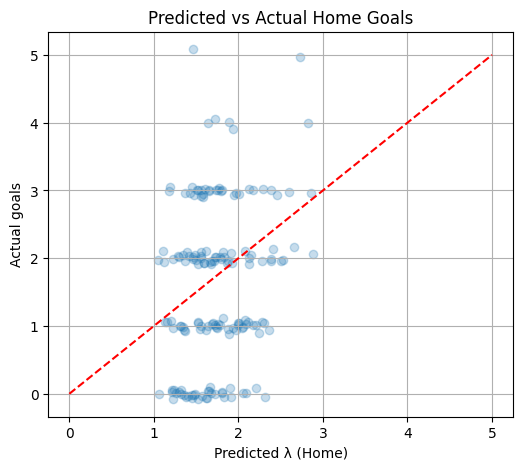

In [ ]:
#home
plt.figure(figsize=(6,5))
plt.scatter(
    home_pred_test,
    y_home_test + np.random.normal(0, 0.05, size=len(y_home_test)),
    alpha=0.25
)
plt.plot([0,5],[0,5],'r--')
plt.xlabel("Predicted λ (Home)")
plt.ylabel("Actual goals")
plt.title("Predicted vs Actual Home Goals")
plt.grid(True)
plt.show()



####PoissonRegressor là linear model

- Trục **X**: `Predicted λ (Home)` = **kỳ vọng số bàn đội nhà** mà mô hình Poisson dự đoán cho từng trận (λ_home).
- Trục **Y**: `Actual goals` = **số bàn thực tế** đội nhà ghi.
- Đường đỏ đứt đoạn `y = x` là **đường dự đoán hoàn hảo**:
  - Điểm nằm **trên** đường đỏ: thực tế > dự đoán → mô hình **underpredict** (dự đoán thiếu).
  - Điểm nằm **dưới** đường đỏ: thực tế < dự đoán → mô hình **overpredict** (dự đoán dư).
---
####Insight
**(1) Mô hình bị “co về trung bình” (regression to the mean)**
- Phần lớn dự đoán λ_home tập trung quanh **~1.3–2.3**.
- Khi thực tế bùng nổ 4–5 bàn, nhiều điểm nằm **trên** đường đỏ → mô hình thường **không đẩy λ đủ cao** để theo kịp các trận “nổ tài” cực đoan.
- Khi thực tế về 0 bàn, nhiều điểm nằm **dưới** đường đỏ → mô hình có xu hướng **dự đoán cao hơn 0**, vì Poisson + linear model rất khó “dám” dự đoán sát 0 trong nhiều bối cảnh.

**(2) Dải dự đoán bị nén**
- Trục X gần như không có điểm ở vùng rất thấp (<1.0) hoặc rất cao (>3.0).
- Điều này khớp với kết quả đã thấy trước đó: min/max λ_home ~ **1.05 → 2.88**.
- Hệ quả: mô hình phân biệt trận “dễ vs khó” có, nhưng **chưa đủ mạnh** để tách rõ các kịch bản cực đoan.

In [ ]:
import pandas as pd
import numpy as np

def count_by_predicted_bins(y_true, y_pred, bins):
    df = pd.DataFrame({
        "actual_goals": y_true,
        "pred_lambda": y_pred
    })

    df["pred_bin"] = pd.cut(df["pred_lambda"], bins=bins)

    table = (
        df
        .groupby(["pred_bin", "actual_goals"])
        .size()
        .unstack(fill_value=0)
    )

    return table

In [ ]:
bins = [0, 1, 1.5, 2, 2.5, 3, 5]

home_table = count_by_predicted_bins(
    y_home_test,
    home_pred_test,
    bins
)

home_table

/tmp/ipython-input-985998159.py:14: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  .groupby(["pred_bin", "actual_goals"])


actual_goals,0,1,2,3,4,5
pred_bin,,,,,,
"(0.0, 1.0]",0,0,0,0,0,0
"(1.0, 1.5]",16,9,14,6,0,1
"(1.5, 2.0]",14,20,21,16,4,0
"(2.0, 2.5]",4,12,8,6,0,0
"(2.5, 3.0]",0,0,4,2,1,1
"(3.0, 5.0]",0,0,0,0,0,0


a) Bin (1.0, 1.5] — mô hình đánh giá “low-ish scoring”
- Có nhiều trường hợp thực tế vẫn là 0–2 bàn, nhưng vẫn có outlier 5 bàn.
- Điều này cho thấy: khi λ thấp, mô hình chủ yếu kỳ vọng trận ít bàn, nhưng vẫn có các trận nổ bàn mà feature không báo trước.

---
b) Bin (1.5, 2.0] là “trung tâm”
- Đây là vùng có nhiều mẫu nhất.
- Actual goals trải rộng từ 0 đến 4, tập trung nhiều ở 1–3.
- Đây thường là vùng mô hình Poisson hoạt động ổn nhất: “match bình thường”, không quá extreme.

---
c) Bin (2.5, 3.0] có rất ít mẫu
- Chỉ một số ít trận mô hình thật sự đẩy λ lên cao.
- Nhưng khi đã ở bin này, actual goals phần lớn là 2–3 (và vẫn có 4–5).
- Tức là ngay cả khi “đánh giá cao”, mô hình vẫn **chưa đủ sắc** để tách riêng hẳn nhóm bùng nổ.


###AWAY

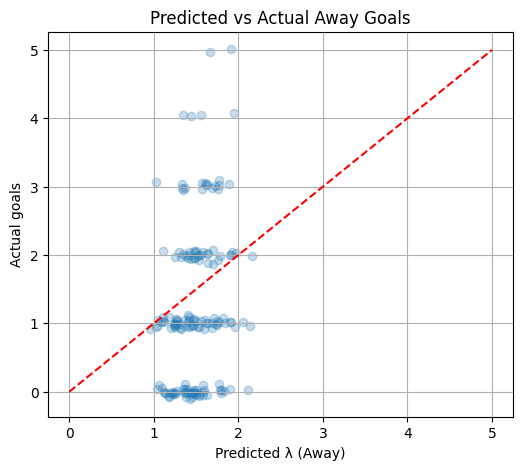

In [ ]:
# AWAY
plt.figure(figsize=(6,5))
plt.scatter(
    away_pred_test,
    y_away_test + np.random.normal(0, 0.05, size=len(y_away_test)),
    alpha=0.25
)
plt.plot([0,5],[0,5],'r--')
plt.xlabel("Predicted λ (Away)")
plt.ylabel("Actual goals")
plt.title("Predicted vs Actual Away Goals")
plt.grid(True)
plt.show()

####Insight
**(1) λ_away bị nén mạnh quanh ~1.0–2.1**
- Qua quan sát, có thể thấy các điểm trên trục X gần như chỉ nằm trong khoảng ~1 đến ~2.2.
- Điều này khớp với thống kê trước đó: λ_away min/max ~ **0.96 → 2.17**.
- Hệ quả: mô hình **hiếm khi** tạo dự đoán “rất thấp” (<1) hoặc “rất cao” (>2.5).

**(2) Regression-to-the-mean rõ rệt**
- Khi actual = 0, nhiều điểm rơi ở X ~1.1–1.6 → mô hình vẫn “nghĩ” đội khách có bàn, dẫn tới **overpredict** trong các trận tịt ngòi.
- Khi actual = 4–5, nhiều điểm nằm **trên** đường đỏ vì X chỉ ~1.6–2.0 → mô hình **underpredict** các trận bùng nổ.

**(3) Dù vậy, mô hình vẫn có “tín hiệu”**
- Vùng λ cao hơn (gần 2.0) có xu hướng xuất hiện nhiều actual 2–3 hơn so với vùng λ ~1.1–1.4.
- Nghĩa là mô hình vẫn phân biệt được phần nào “trận dễ ghi bàn vs khó ghi bàn”, chỉ là chưa đủ biên độ.

In [ ]:
def count_by_predicted_bins(y_true, y_pred, bins):
    df = pd.DataFrame({
        "actual_goals": y_true,
        "pred_lambda": y_pred
    })

    df["pred_bin"] = pd.cut(df["pred_lambda"], bins=bins)

    table = (
        df
        .groupby(["pred_bin", "actual_goals"], observed=False)
        .size()
        .unstack(fill_value=0)
    )

    return table

bins = [0, 1, 1.5, 2, 2.5, 3, 5]

away_table = count_by_predicted_bins(
    y_away_test,
    away_pred_test,
    bins
)

away_table

actual_goals,0,1,2,3,4,5
pred_bin,,,,,,
"(0.0, 1.0]",0,1,0,0,0,0
"(1.0, 1.5]",35,33,14,5,2,0
"(1.5, 2.0]",13,20,17,11,2,2
"(2.0, 2.5]",1,2,1,0,0,0
"(2.5, 3.0]",0,0,0,0,0,0
"(3.0, 5.0]",0,0,0,0,0,0


#### a) Bin (1.0, 1.5] là nhóm đông nhất
- Actual goals trải từ 0 đến 4:
  - 0 bàn: 35
  - 1 bàn: 33
  - 2 bàn: 14
  - 3 bàn: 5
  - 4 bàn: 2
- Đây là vùng “match bình thường” của away: phần lớn rơi vào 0–2 bàn, đúng với bóng đá thực tế.

#### b) Bin (1.5, 2.0] — mô hình đánh giá cao hơn
- Actual goals có xu hướng cao hơn:
  - 2 bàn: 17
  - 3 bàn: 11
  - vẫn có 4–5 bàn (2 và 2)
- Tuy nhiên vẫn còn 0–1 bàn khá nhiều (13 và 20) → mô hình chưa đủ chắc để “khoanh vùng” trận chắc chắn nhiều bàn.

####c) Bin (2.0, 2.5] rất ít mẫu
- Chỉ vài trận → khó kết luận mạnh.
- Nhưng cũng cho thấy mô hình gần như **không mở rộng** λ_away vượt 2.0.


#Predict

In [ ]:
from scipy.stats import poisson
import numpy as np
import pandas as pd

def outcome_probs_from_lambdas(lam_home, lam_away, max_goals=10):
  #tạo range mà bàn thắng có thể xảy ra
  #từ 0 tới 10 (đủ lớn, cực kỳ ít trận >10 bàn)
    hg = np.arange(0, max_goals + 1)
    ag = np.arange(0, max_goals + 1)

    #tính phân phối poisson cho từng loại
    #P(h/a | lambda)
    p_h = poisson.pmf(hg, lam_home)
    p_a = poisson.pmf(ag, lam_away)

    #tạo ma trận xác suất tỉ số (scoreline matrix)
    #P(H = i, A = j) = P(H=i) * P(A = j)
    M = np.outer(p_h, p_a)

    #Xác suất hòa (trên đường chéo)
    p_draw = np.trace(M)
    #xác suất home thắng (lấy tam giác dưới đường chéo)
    p_home = np.tril(M, -1).sum()
    #xác suất away thắng (tam giác trên)
    p_away = np.triu(M, 1).sum()

    #tổng xác suất
    s = p_home + p_draw + p_away
    return p_home/s, p_draw/s, p_away/s


In [ ]:
def build_Xrow_for_any_fixture(home, away, asof_date=None, n_recent=3):
    #tạo khoảng thời gian chốt dữ liệu (nếu user có nhập)
    #không dùng data từ ngày này trở đi để tránh leakage
    if asof_date is None:
        cutoff = df["Date"].max() + pd.Timedelta(days=1)
    else:
        cutoff = pd.to_datetime(asof_date)

    #lấy lịch sử home/away trước cutoff, lấy n_recent (3) trận mới nhất (phong độ gần nhất -> phản ánh tốt hơn)
    home_hist = df[(df["Home"] == home) & (df["Date"] < cutoff)].sort_values("Date").tail(n_recent)
    away_hist = df[(df["Away"] == away) & (df["Date"] < cutoff)].sort_values("Date").tail(n_recent)

    if len(home_hist) == 0:
        raise ValueError(f"Không có lịch sử sân nhà cho đội: {home} (trước {cutoff.date()})")
    if len(away_hist) == 0:
        raise ValueError(f"Không có lịch sử sân khách cho đội: {away} (trước {cutoff.date()})")

    # ✅ dùng trung bình vài trận gần nhất cho ổn định
    home_row = home_hist.select_dtypes(include=[np.number]).mean()
    away_row = away_hist.select_dtypes(include=[np.number]).mean()

    X_cols = X_train.columns  # hoặc feature_columns nếu load từ joblib
    X_row = pd.Series(index=X_cols, dtype=float)

    # Nếu thiếu feature thì để NaN, pipeline imputer sẽ fill median (nếu dùng SimpleImputer)
    X_row[:] = np.nan

    # 1) fill home_*, away_*

    for c in X_cols:
        if c.startswith("home_"):
            X_row[c] = home_row.get(c, np.nan) #nếu có thì lấy giá trị c, ko thì fill NaN
        elif c.startswith("away_"):
            X_row[c] = away_row.get(c, np.nan)

    # 2) tính lại diff_*
    #chênh lệch sức mạnh giữa 2 đội, diff_feature = home_feature - away_feature
    for c in X_cols:
        if c.startswith("diff_"):
            base = c[len("diff_"):]              # ví dụ diff_ewm_xgf thì base là ewm_xgf
            #tạo map theo home/away
            #ví dụ home: home + base = home_ewm_xgf
            hc = "home_" + base
            ac = "away_" + base
            if hc in X_cols and ac in X_cols:
                if pd.notna(X_row[hc]) and pd.notna(X_row[ac]):
                    X_row[c] = X_row[hc] - X_row[ac]

    # 3) rest_diff (nếu bạn có cột này)
    if "rest_diff" in X_cols:
        if "home_rest_days" in X_cols and "away_rest_days" in X_cols:
            if pd.notna(X_row["home_rest_days"]) and pd.notna(X_row["away_rest_days"]):
                X_row["rest_diff"] = X_row["home_rest_days"] - X_row["away_rest_days"]

    return pd.DataFrame([X_row], columns=X_cols)

In [ ]:
def pretty_match_prediction(home, away, asof_date=None, max_goals=10):
    # build feature row cho cặp bất kỳ
    X_row = build_Xrow_for_any_fixture(home, away, asof_date=asof_date)

    #dự đoán lambda cho home/away
    lam_home = home_model.predict(X_row)[0]
    lam_away = away_model.predict(X_row)[0]
    lam_total = lam_home + lam_away

    #P_under 2.5 tức là <=2 nên = P(goals <= 2)
    p_under_25 = poisson.cdf(2, lam_total)
    p_over_25 = 1 - p_under_25

    #xác suất 1X2 từ lambda
    pH, pD, pA = outcome_probs_from_lambdas(lam_home, lam_away, max_goals)

    probs = {f"{home} WIN": pH, "DRAW": pD, f"{away} WIN": pA}
    pred_label = max(probs, key=probs.get)

    def bar(p, width=26):
        filled = int(round(p * width))
        return "█"*filled + "░"*(width-filled)

    print("┌" + "─"*62 + "┐")
    print(f"│  Fixture: {home} vs {away:<44}│")
    if asof_date is None:
        print(f"│  As-of:  latest available in dataset{' ' * 31}│")
    else:
        print(f"│  As-of:  {pd.to_datetime(asof_date).date()}{' ' * 42}│")
    print("├" + "─"*62 + "┤")
    print(f"│  λ_home: {lam_home:6.3f}   λ_away: {lam_away:6.3f}   λ_total: {lam_total:6.3f} │")
    print("├" + "─"*62 + "┤")
    print(f"│  HOME WIN  {pH*100:6.2f}%  {bar(pH):<26}            │")
    print(f"│  DRAW      {pD*100:6.2f}%  {bar(pD):<26}            │")
    print(f"│  AWAY WIN  {pA*100:6.2f}%  {bar(pA):<26}            │")
    print("├" + "─"*62 + "┤")
    print(f"│  OVER  2.5 {p_over_25*100:6.2f}%  {bar(p_over_25):<26}            │")
    print(f"│  UNDER 2.5 {p_under_25*100:6.2f}%  {bar(p_under_25):<26}            │")
    print("├" + "─"*62 + "┤")
    print(f"│  Prediction: {pred_label:<48}│")
    print("└" + "─"*62 + "┘")

    return {
        "lambda_home": lam_home,
        "lambda_away": lam_away,
        "P_home_win": pH,
        "P_draw": pD,
        "P_away_win": pA,
        "P_over_25": p_over_25,
        "P_under_25": p_under_25,
        "prediction": pred_label
    }


In [ ]:
pretty_match_prediction(
    home="Luton Town",
    away="Leeds United"
)

┌──────────────────────────────────────────────────────────────┐
│  Fixture: Luton Town vs Leeds United                                │
│  As-of:  latest available in dataset                               │
├──────────────────────────────────────────────────────────────┤
│  λ_home:  1.363   λ_away:  1.758   λ_total:  3.121 │
├──────────────────────────────────────────────────────────────┤
│  HOME WIN   29.89%  ████████░░░░░░░░░░░░░░░░░░            │
│  DRAW       23.28%  ██████░░░░░░░░░░░░░░░░░░░░            │
│  AWAY WIN   46.84%  ████████████░░░░░░░░░░░░░░            │
├──────────────────────────────────────────────────────────────┤
│  OVER  2.5  60.35%  ████████████████░░░░░░░░░░            │
│  UNDER 2.5  39.65%  ██████████░░░░░░░░░░░░░░░░            │
├──────────────────────────────────────────────────────────────┤
│  Prediction: Leeds United WIN                                │
└──────────────────────────────────────────────────────────────┘


{'lambda_home': np.float64(1.3634385921328291),
 'lambda_away': np.float64(1.7580351176322415),
 'P_home_win': np.float64(0.2988750785378962),
 'P_draw': np.float64(0.23276661010881283),
 'P_away_win': np.float64(0.4683583113532911),
 'P_over_25': np.float64(0.6034673445016381),
 'P_under_25': np.float64(0.39653265549836186),
 'prediction': 'Leeds United WIN'}